#### Обработка данных

In [1]:
import pandas as pd
import numpy as np

import plotly.plotly as py
import plotly.graph_objs as go

from scipy import optimize as opt
import scipy
import scipy.odr as odr

from statsmodels.stats.weightstats import *

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('experiment.csv') # Считываем данные

In [3]:
data.head(5) # Посмотрим на несколько значений

,feature1,feature2
0,0.07,0.27
1,0.12,0.35
2,0.20,0.45
3,0.27,0.52
4,0.32,0.57


Сгенерируем новые признаки и значения измерений, вычислим ошибки и определимся с размерностями в данных

$d = 0.16 \ cm$

$sigma_d^{syst} = 0.01 \ cm$

$s = 42 \ cm^2$

$sigma_s^{syst} = 1 \ cm^2$

$\epsilon^{syst}_m = 0.03 $

$sigma^{syst}_u = 0.02 \ V$ 

In [4]:
d = 0.16 
sigma_syst_d = 0.01
s = 42 
sigma_syst_s = 1
epsilon_syst_m = 0.03
sigma_syst_u = 20

feature1 = $m, \ g$

feature2 = $U_{isu}, \ V$ ($kV$)

feature3 = $F, \ N$ = feature1 $\cdot 10^{-2}$

feature4 = $U_{isu}^2, \ B^2$

feature5 = $2 d \sqrt{\frac{2 \pi F}{S}}, \ g^{1/2} {cm}^{1/2} s^{-1} \ = \ U_{cgs}$

feature6 = $\sigma_F^{syst} \ = \ 0.03 \cdot feature3$ 

feature7 = $\sigma_{U^2}^{syst} \ = \ 2U \sigma^{syst}_u $

feature8 = $\sigma_{U_{cgs}}^{syst}$

In [5]:
data['feature1'] = data['feature1']
data['feature2'] = data['feature2']*1000
data.insert(2, 'feature3', data['feature1']*0.01)
data.insert(3, 'feature4', data['feature2']*data['feature2'])
data.insert(4, 'feature5', data['feature3'].apply(np.sqrt)*2*d*sqrt(2*pi/s*100000))
data.insert(5, 'feature6', data['feature3']*epsilon_syst_m)
data.insert(6, 'feature7', sigma_syst_u * 2 * data['feature2'])
data.insert(7, 'feature8', data['feature5']*(1/d*sigma_syst_d + 1/(data['feature3']+s)*0.5))
data.insert(8, 'empty', 1)

In [6]:
data

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,empty
0,0.07,270,0.0007,72900,1.035534,0.000021,10800,0.077048,1
1,0.12,350,0.0012,122500,1.355832,0.000036,14000,0.100880,1
2,0.20,450,0.0020,202500,1.750372,0.000060,18000,0.130235,1
3,0.27,520,0.0027,270400,2.033748,0.000081,20800,0.151319,1
4,0.32,570,0.0032,324900,2.214064,0.000096,22800,0.164735,1
5,0.37,610,0.0037,372100,2.380763,0.000111,24400,0.177138,1
6,0.42,650,0.0042,422500,2.536529,0.000126,26000,0.188727,1
7,0.47,710,0.0047,504100,2.683269,0.000141,28400,0.199644,1
8,0.55,730,0.0055,532900,2.902663,0.000165,29200,0.215967,1
9,0.65,730,0.0065,532900,3.155527,0.000195,29200,0.234780,1


Удалим 9 и 10 измерения в силу выброса, далее этот факт будет рассмотрен подробнее

In [7]:
data_e = data[8:10] # data_e массив из этих двух значений
data = data.drop([9,8])

In [8]:
data

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,empty
0,0.07,270,0.0007,72900,1.035534,0.000021,10800,0.077048,1
1,0.12,350,0.0012,122500,1.355832,0.000036,14000,0.100880,1
2,0.20,450,0.0020,202500,1.750372,0.000060,18000,0.130235,1
3,0.27,520,0.0027,270400,2.033748,0.000081,20800,0.151319,1
4,0.32,570,0.0032,324900,2.214064,0.000096,22800,0.164735,1
5,0.37,610,0.0037,372100,2.380763,0.000111,24400,0.177138,1
6,0.42,650,0.0042,422500,2.536529,0.000126,26000,0.188727,1
7,0.47,710,0.0047,504100,2.683269,0.000141,28400,0.199644,1
10,0.17,380,0.0017,144400,1.613763,0.000051,15200,0.120071,1
11,0.65,770,0.0065,592900,3.155527,0.000195,30800,0.234780,1


In [9]:
data_e

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,empty
8,0.55,730,0.0055,532900,2.902663,0.000165,29200,0.215967,1
9,0.65,730,0.0065,532900,3.155527,0.000195,29200,0.234780,1


#### Визуализация и информация о данных

Изобразим полученные данные

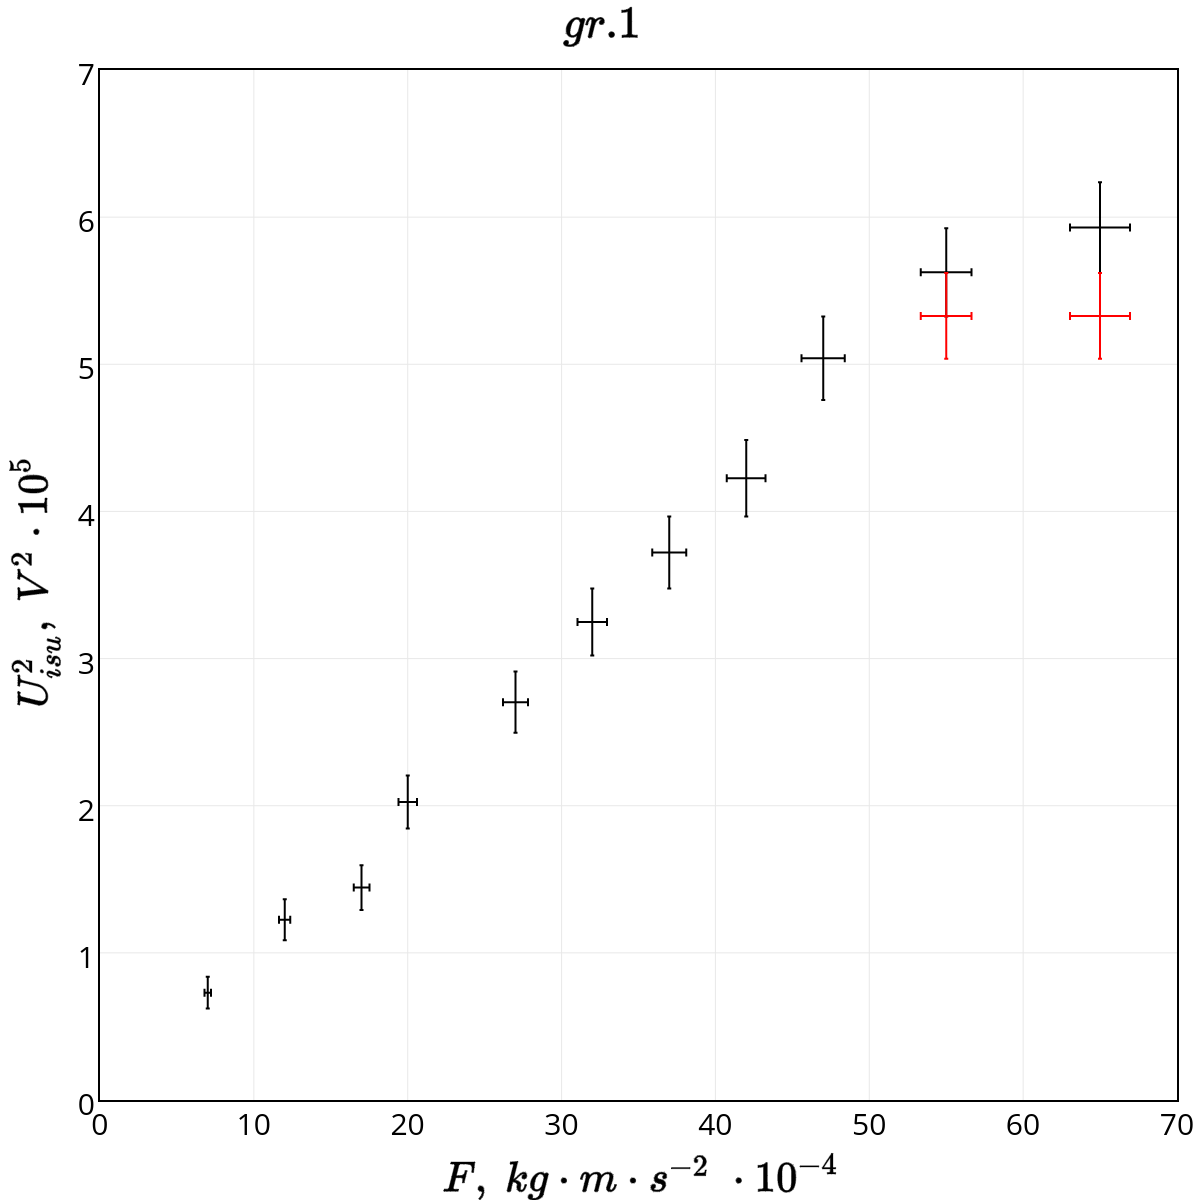

In [10]:
trace1 = go.Scatter(
    x = data['feature3']*10000,
    y = data['feature4']/100000,
    mode = 'markers',
    name = 'gr1',
    error_y = dict(
        type = 'data',
        array = data['feature7']/100000,
        visible = True,
        color = '#000000',
        thickness = 2,
        width = 2
    ),
    error_x = dict(
        type = 'data',
        array = data['feature6']*10000,
        visible = True,
        color = '#000000'
    ),
    marker = dict(
        size = 1,
        opacity = 1,
        color = '#000000'
    )
)
trace2 = go.Scatter(
    x = data_e['feature3']*10000,
    y = data_e['feature4']/100000,
    mode = 'markers',
    name = 'gr1',
    error_y = dict(
        type = 'data',
        array = data_e['feature7']/100000,
        visible = True,
        color = '#ff0000',
        thickness = 2,
        width = 2
    ),
    error_x = dict(
        type = 'data',
        array = data_e['feature6']*10000,
        visible = True,
        color = '#ff0000',
    ),
    marker = dict(
        size = 1,
        opacity = 1,
        color = '#ff0000'
    )
)

trace0 = [trace1, trace2]

layout = go.Layout(
    title = "$gr.1$",
    width = 1200,
    height = 1200,
    font = dict(
        size = 30,
        color = '#000000'
        ),
    showlegend=False,
    paper_bgcolor = '#ffffff',
    xaxis = dict(
        title = '$F,~kg \cdot m \cdot s^{-2}~\cdot 10^{-4}$',
        range = [0, 70],
        zeroline = False,
        ticklen = 0,
        color = '#000000',
        mirror = True,
        showline = True,
        linewidth = 2,
        titlefont = dict(
            size = 40,
            color = '#000000' 
            )
    ),
    yaxis = dict(
        title = '$U_{isu}^2,~V^2 \cdot 10^5$',
        range = [0, 7],
        zeroline = False,
        ticklen = 0,
        color = '#000000',
        mirror = True,
        showline = True,
        linewidth = 2,
        titlefont = dict(
            size = 40,
            color = '#000000' 
            )
    ),
    margin = dict(
        l = 100,
        r = 23,
        t = 70,
        b = 100,
        pad = 0 
    )
    
)

fig = go.Figure(data=trace0, layout=layout)
#py.iplot(figure, filename='basic-error-bar')
py.image.save_as(fig, 'my_plot1.png')
#! open my_plot.png
from IPython.display import Image
Image("my_plot1.png", width=500)

#### Анализ

Построим стартовую LS регрессию

#### Curve fit (without sigma)

In [11]:
X = np.reshape(np.array(data['feature3']), (1, len(np.array(data['feature3']))))
Y = np.reshape(np.array(data['feature4']), (1, len(np.array(data['feature4']))))

In [12]:
def f(x, b):
    return b*x
parameters_opt_1, parameters_cov_1 = opt.curve_fit(f, X[0], Y[0])
parameters_opt_1 = parameters_opt_1[0]
parameters_sigma_1 = np.sqrt(np.diag(parameters_cov_1))[0]

In [13]:
print "y  = ({:.3f})*x".format(parameters_opt_1)
print "(+-)({:.3f})*x".format(parameters_sigma_1)

y  = (99076705.798)*x
(+-)(1840983.209)*x


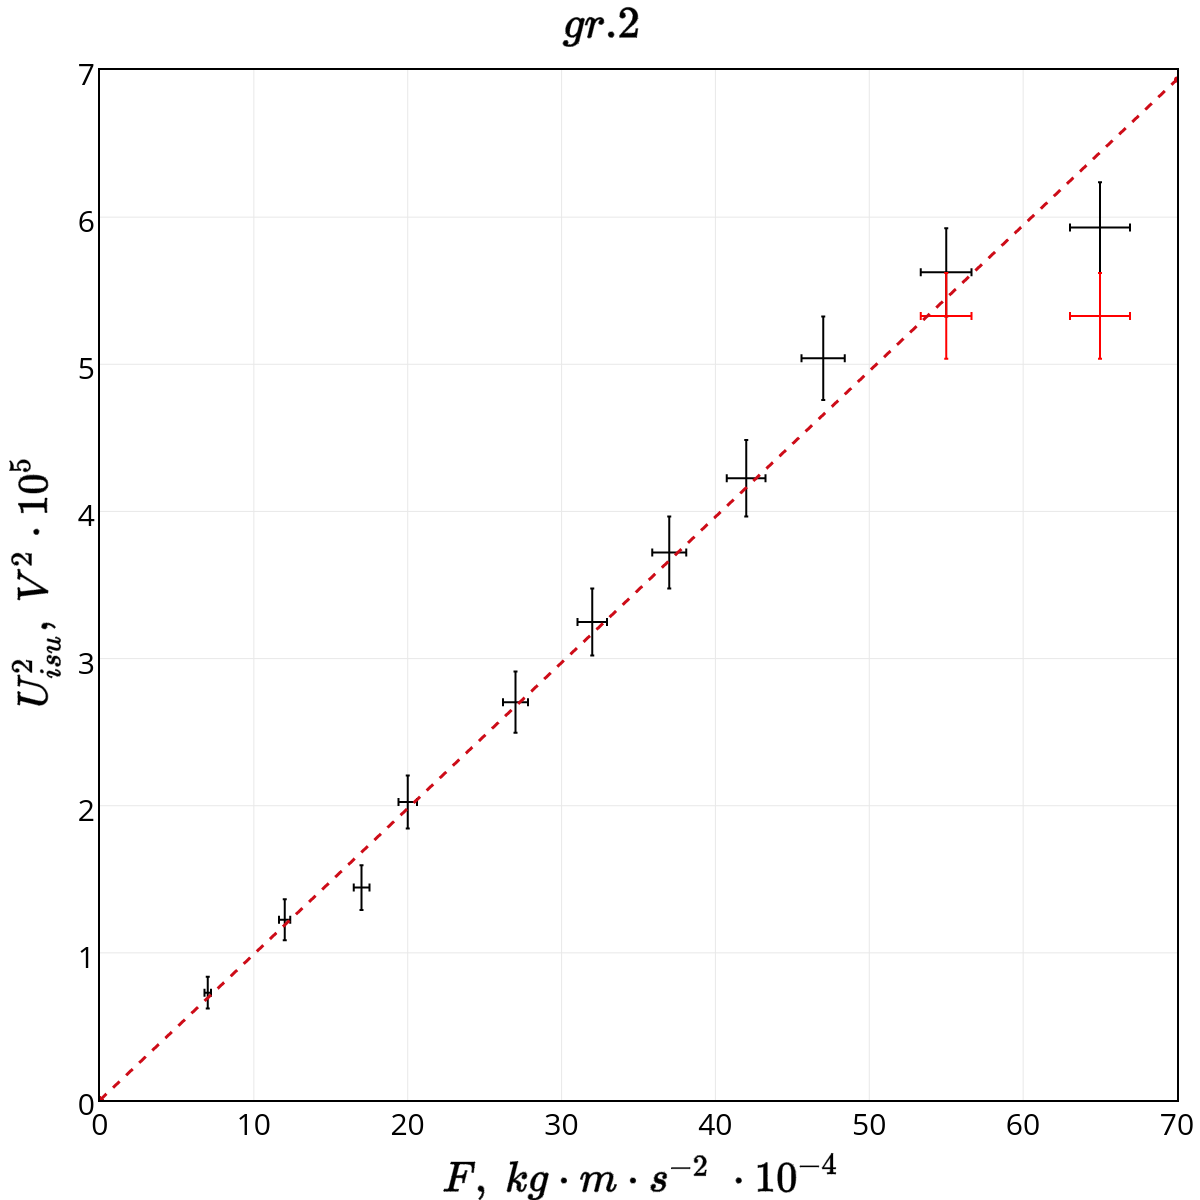

In [14]:
trace3 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.0001, 0.0007*parameters_opt_1*0.0001],
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 3,
        dash = 'dash')
)

trace4 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.00001, 0.0007*(parameters_opt_1-parameters_sigma_1)*0.0001],
    line = dict(
        color = ('#003366'),
        width = 3,
        dash = 'dash')
)

trace5 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.00001, 0.0007*(parameters_opt_1+parameters_sigma_1)*0.0001],
    line = dict(
        color = ('#003366'),
        width = 3,
        dash = 'dash')
)

trace6 = go.Scatter(
    x = [0.0*10000.0, 0.0007*10000.0],
    y = [0.0*0.00001, 0.0007*(parameters_opt_1-2*parameters_sigma_1)*0.0001],
    line = dict(
        color = ('#003366'),
        width = 2,
        dash = 'dash')
)

trace7 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.00001, 0.0007*(parameters_opt_1+2*parameters_sigma_1)*0.0001],
    line = dict(
        color = ('#003366'),
        width = 2,
        dash = 'dash')
)


trace1 = go.Scatter(
    x = data['feature3']*10000,
    y = data['feature4']/100000,
    mode = 'markers',
    name = 'gr1',
    error_y = dict(
        type = 'data',
        array = data['feature7']/100000,
        visible = True,
        color = '#000000',
        thickness = 2,
        width = 2
    ),
    error_x = dict(
        type = 'data',
        array = data['feature6']*10000,
        visible = True,
        color = '#000000'
    ),
    marker = dict(
        size = 1,
        opacity = 1,
        color = '#000000'
    )
)
trace2 = go.Scatter(
    x = data_e['feature3']*10000,
    y = data_e['feature4']/100000,
    mode = 'markers',
    name = 'gr1',
    error_y = dict(
        type = 'data',
        array = data_e['feature7']/100000,
        visible = True,
        color = '#ff0000',
        thickness = 2,
        width = 2
    ),
    error_x = dict(
        type = 'data',
        array = data_e['feature6']*10000,
        visible = True,
        color = '#ff0000',
    ),
    marker = dict(
        size = 1,
        opacity = 1,
        color = '#ff0000'
    )
)

trace0 = [trace1, trace2, trace3] #, trace4, trace5, trace6, trace7]

layout = go.Layout(
    title = "$gr.2$",
    width = 1200,
    height = 1200,
    font = dict(
        size = 30,
        color = '#000000'
        ),
    showlegend=False,
    paper_bgcolor = '#ffffff',
    xaxis = dict(
        title = '$F,~kg \cdot m \cdot s^{-2}~\cdot 10^{-4}$',
        range = [0, 70],
        zeroline = False,
        ticklen = 0,
        color = '#000000',
        mirror = True,
        showline = True,
        linewidth = 2,
        titlefont = dict(
            size = 40,
            color = '#000000' 
            )
    ),
    yaxis = dict(
        title = '$U_{isu}^2,~V^2 \cdot 10^5$',
        range = [0, 7],
        zeroline = False,
        ticklen = 0,
        color = '#000000',
        mirror = True,
        showline = True,
        linewidth = 2,
        titlefont = dict(
            size = 40,
            color = '#000000' 
            )
    ),
    margin = dict(
        l = 100,
        r = 23,
        t = 70,
        b = 100,
        pad = 0 
    )
    
)

fig = go.Figure(data=trace0, layout=layout)
#py.iplot(figure, filename='basic-error-bar')
py.image.save_as(fig, 'my_plot2.png')
#! open my_plot.png
from IPython.display import Image
Image("my_plot2.png", width=500)

По данной модели построим распределение остатков/ошибок на данных

In [15]:
err = pd.DataFrame()
err.insert(0, '0', data['feature4']-parameters_opt_1*data['feature3'])
err.insert(1, '1', data['feature3'])

In [16]:
err_e = pd.DataFrame()
err_e.insert(0, '0', data_e['feature4']-parameters_opt_1*data_e['feature3'])
err_e.insert(1, '1', data_e['feature3'])

In [17]:
err

,0,1
0,3546.305941,0.0007
1,3607.953043,0.0012
2,4346.588404,0.0020
3,2892.894346,0.0027
4,7854.541447,0.0032
5,5516.188548,0.0037
6,6377.835649,0.0042
7,38439.482750,0.0047
10,-24030.399856,0.0017
11,-51098.587686,0.0065


In [18]:
err_e

,0,1
8,-12021.881889,0.0055
9,-111098.587686,0.0065


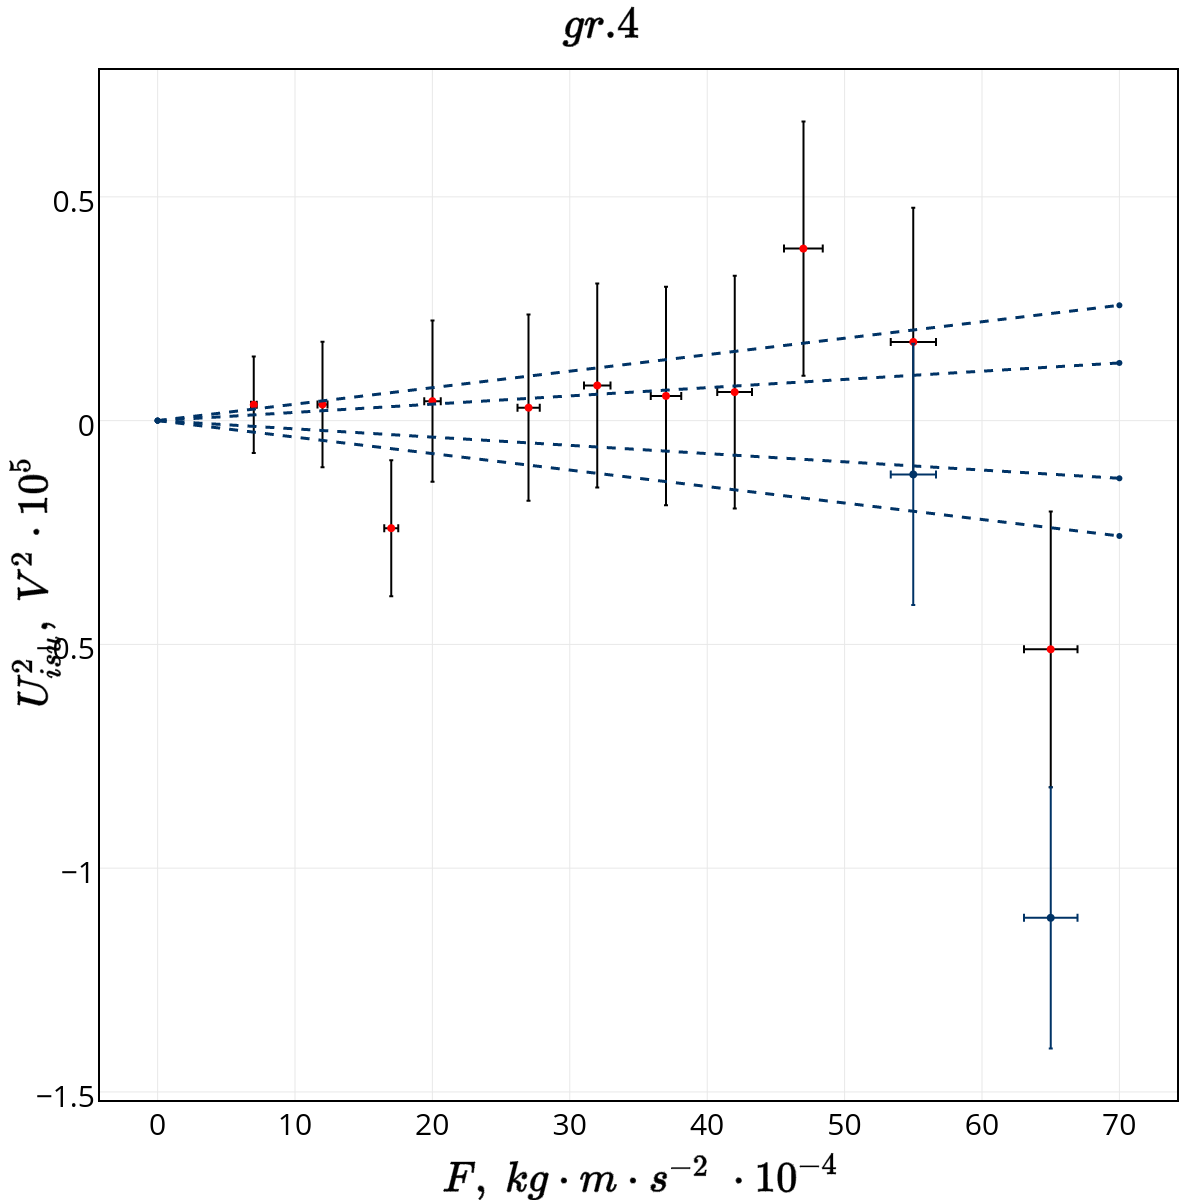

In [19]:
trace1 = go.Scatter(
    x = err['1']*10000,
    y = err['0']/100000,
    mode = 'markers',
    name = 'gr1',
    error_y = dict(
        type = 'data',
        array = data['feature7']/100000,
        visible = True,
        color = '#000000',
        thickness = 2,
        width = 2
    ),
    error_x = dict(
        type = 'data',
        array = data['feature6']*10000,
        visible = True,
        color = '#000000'
    ),
    marker = dict(
        size = 8,
        opacity = 1,
        color = '#ff0000'
    )
)

trace2 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.00001, 0.0007*parameters_sigma_1*0.0001],
    line = dict(
        color = ('#003366'),#51d9c5
        width = 3,
        dash = 'dash')
)

trace3 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.00001, -0.0007*parameters_sigma_1*0.0001],
    line = dict(
        color = ('#003366'),#51d9c5
        width = 3,
        dash = 'dash')
)

trace4 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.00001, -2*0.0007*parameters_sigma_1*0.0001],
    line = dict(
        color = ('#003366'),
        width = 3,
        dash = 'dash')
)

trace5 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.00001, 2*0.0007*parameters_sigma_1*0.0001],
    line = dict(
        color = ('#003366'),
        width = 3,
        dash = 'dash')
)

trace6 = go.Scatter(
    x = err_e['1']*10000,
    y = err_e['0']/100000,
    mode = 'markers',
    name = 'gr1',
    error_y = dict(
        type = 'data',
        array = data_e['feature7']/100000,
        visible = True,
        color = '#003366',
        thickness = 2,
        width = 2
    ),
    error_x = dict(
        type = 'data',
        array = data_e['feature6']*10000,
        visible = True,
        color = '#003366',
    ),
    marker = dict(
        size = 8,
        opacity = 1,
        color = '#003366'
    )
)


trace0 = [trace1, trace2, trace3, trace4, trace5, trace6]

layout = go.Layout(
    title = "$gr.4$",
    width = 1200,
    height = 1200,
    font = dict(
        size = 30,
        color = '#000000'
        ),
    showlegend=False,
    paper_bgcolor = '#ffffff',
    xaxis = dict(
        title = '$F,~kg \cdot m \cdot s^{-2}~\cdot 10^{-4}$',
        #range = [0, 70],
        zeroline = False,
        ticklen = 0,
        color = '#000000',
        mirror = True,
        showline = True,
        linewidth = 2,
        titlefont = dict(
            size = 40,
            color = '#000000' 
            )
    ),
    yaxis = dict(
        title = '$U_{isu}^2,~V^2 \cdot 10^5$',
        #range = [0, 7],
        zeroline = False,
        ticklen = 0,
        color = '#000000',
        mirror = True,
        showline = True,
        linewidth = 2,
        titlefont = dict(
            size = 40,
            color = '#000000' 
            )
    ),
    margin = dict(
        l = 100,
        r = 23,
        t = 70,
        b = 100,
        pad = 0 
    )
    
)

fig = go.Figure(data=trace0, layout=layout)
#py.iplot(figure, filename='basic-error-bar')
py.image.save_as(fig, 'my_plot4.png')
#! open my_plot.png
from IPython.display import Image
Image("my_plot4.png", width=500)

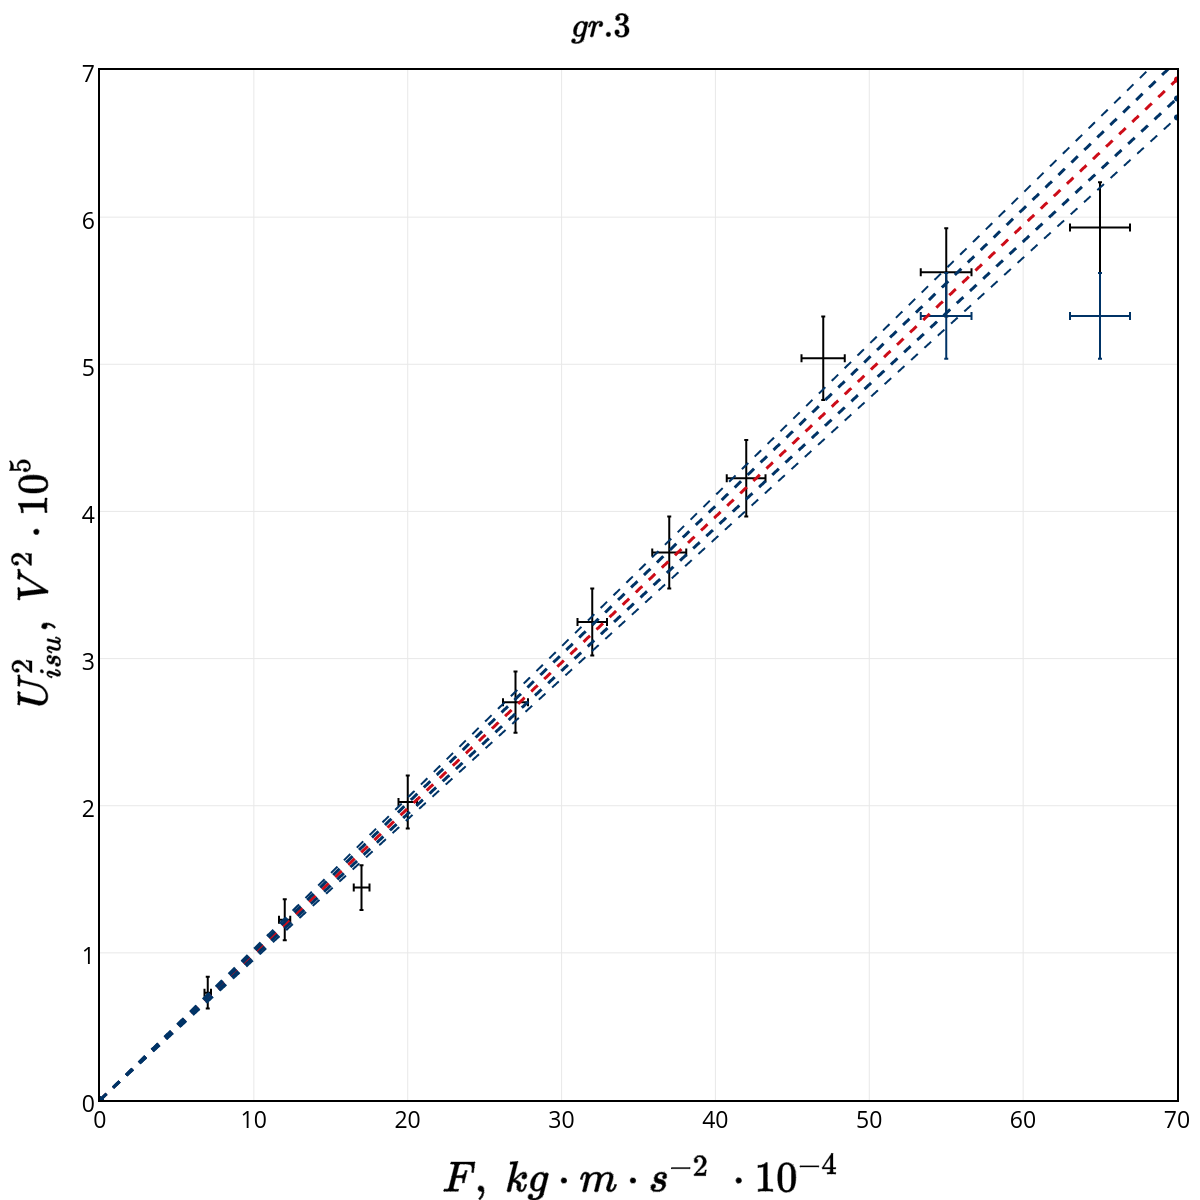

In [20]:
trace3 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.0001, 0.0007*parameters_opt_1*0.0001],
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 3,
        dash = 'dash')
)

trace4 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.00001, 0.0007*(parameters_opt_1-parameters_sigma_1)*0.0001],
    line = dict(
        color = ('#003366'),
        width = 3,
        dash = 'dash')
)

trace5 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.00001, 0.0007*(parameters_opt_1+parameters_sigma_1)*0.0001],
    line = dict(
        color = ('#003366'),
        width = 3,
        dash = 'dash')
)

trace6 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.00001, 0.0007*(parameters_opt_1-2*parameters_sigma_1)*0.0001],
    line = dict(
        color = ('#003366'),
        width = 2,
        dash = 'dash')
)

trace7 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.00001, 0.0007*(parameters_opt_1+2*parameters_sigma_1)*0.0001],
    line = dict(
        color = ('#003366'),
        width = 2,
        dash = 'dash')
)


trace1 = go.Scatter(
    x = data['feature3']*10000,
    y = data['feature4']/100000,
    mode = 'markers',
    name = 'gr1',
    error_y = dict(
        type = 'data',
        array = data['feature7']/100000,
        visible = True,
        color = '#000000',
        thickness = 2,
        width = 2
    ),
    error_x = dict(
        type = 'data',
        array = data['feature6']*10000,
        visible = True,
        color = '#000000'
    ),
    marker = dict(
        size = 1,
        opacity = 1,
        color = '#000000'
    )
)
trace2 = go.Scatter(
    x = data_e['feature3']*10000,
    y = data_e['feature4']/100000,
    mode = 'markers',
    name = 'gr1',
    error_y = dict(
        type = 'data',
        array = data_e['feature7']/100000,
        visible = True,
        color = '#003366',
        thickness = 2,
        width = 2
    ),
    error_x = dict(
        type = 'data',
        array = data_e['feature6']*10000,
        visible = True,
        color = '#003366',
    ),
    marker = dict(
        size = 1,
        opacity = 1,
        color = '#003366'
    )
)

trace0 = [trace1, trace2, trace3, trace4, trace5, trace6, trace7]

layout = go.Layout(
    title = "$gr.3$",
    width = 1200,
    height = 1200,
    font = dict(
        size = 23,
        color = '#000000'
        ),
    showlegend=False,
    paper_bgcolor = '#ffffff',
    xaxis = dict(
        title = '$F,~kg \cdot m \cdot s^{-2}~\cdot 10^{-4}$',
        range = [0, 70],
        zeroline = False,
        ticklen = 0,
        color = '#000000',
        mirror = True,
        showline = True,
        linewidth = 2,
        titlefont = dict(
            size = 40,
            color = '#000000' 
            )
    ),
    yaxis = dict(
        title = '$U_{isu}^2,~V^2 \cdot 10^5$',
        range = [0, 7],
        zeroline = False,
        ticklen = 0,
        color = '#000000',
        mirror = True,
        showline = True,
        linewidth = 2,
        titlefont = dict(
            size = 40,
            color = '#000000' 
            )
    ),
    margin = dict(
        l = 100,
        r = 23,
        t = 70,
        b = 100,
        pad = 0 
    )
    
)

fig = go.Figure(data=trace0, layout=layout)
#py.iplot(figure, filename='basic-error-bar')
py.image.save_as(fig, 'my_plot3.png')
#! open my_plot.png
from IPython.display import Image
Image("my_plot3.png", width=500)

Исходя из определённых соображений описанных в тексте работы, удалим последнюю точку

In [21]:
data_e = data_e.append(data.ix[11,:])
err_e = err_e.append(err.ix[11,:])
data = data.drop([11], axis=0)
err = err.drop([11], axis=0)

Ошибка для электрической постоянной:

In [22]:
def e (d, s, opt):
    return 2*(d*d)/(s*opt)
def syst_e (e, d, s, systd, systs):
    return 2*e*systd/d + e*systs/s
def stat_e (e, opt, sigma_opt):
    return sqrt((e/opt*sigma_opt)**2)

print e(d, s, parameters_opt_1)
print syst_e(e(d, s, parameters_opt_1), d, s, sigma_syst_d, sigma_syst_s)
print stat_e(e(d, s, parameters_opt_1), parameters_opt_1, parameters_sigma_1)
print sqrt(syst_e(e(d, s, parameters_opt_1), d, s, sigma_syst_d, sigma_syst_s)**2 +
          stat_e(e(d, s, parameters_opt_1), parameters_opt_1, parameters_sigma_1)**2)

1.23040790389e-11
1.83096414269e-12
2.28626928357e-13
1.84518290806e-12


T-критерий Стьюдента, но уже без последнего измерения:

In [23]:
print scipy.stats.ttest_1samp(err['0'], 0.0)
print zconfint(err['0'])

Ttest_1sampResult(statistic=1.3649909837454322, pvalue=0.20540232148498014)
(-2882.4565518404142, 16108.358228203271)


Критерий Шапиро-Уилка:

In [24]:
print "Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % scipy.stats.shapiro(err['0'])

Shapiro-Wilk normality test, W-statistic: 0.834333, p-value: 0.037729


In [25]:
print "Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % scipy.stats.shapiro(err.ix[0:6,0])

Shapiro-Wilk normality test, W-statistic: 0.930643, p-value: 0.556384


In [26]:
data_f = pd.DataFrame()
err_f = pd.DataFrame()
data_f = data_f.append(data.ix[0:6,:])
err_f = err_f.append(err.ix[0:6,:])

#### Построение моделей


In [27]:
X = np.reshape(np.array(data['feature3']), (1, len(np.array(data['feature3']))))
Y = np.reshape(np.array(data['feature4']), (1, len(np.array(data['feature4']))))

Xerr = np.reshape(np.array(data['feature6']), (1, len(np.array(data['feature6']))))
Yerr = np.reshape(np.array(data['feature7']), (1, len(np.array(data['feature7']))))

In [28]:
def f(x, b):
    return b*x

parameters_opt, parameters_cov = opt.curve_fit(f, X[0], Y[0]) #, sigma = Yerr[0], absolute_sigma=True)

print("y  = ({:.3f})*x".format(parameters_opt[0]))
print("(+-)({:.3f})*x".format(np.sqrt(np.diag(parameters_cov))[0]))

print e(d, s, parameters_opt[0])
print syst_e(e(d, s, parameters_opt[0]), d, s, sigma_syst_d, sigma_syst_s)
print stat_e(e(d, s, parameters_opt[0]), parameters_opt[0], np.sqrt(np.diag(parameters_cov))[0])
print sqrt(syst_e(e(d, s, parameters_opt[0]), d, s, sigma_syst_d, sigma_syst_s)**2 +
          stat_e(e(d, s, parameters_opt[0]), parameters_opt[0], np.sqrt(np.diag(parameters_cov))[0])**2)

y  = (102095618.984)*x
(+-)(1249934.489)*x
1.19402539617e-11
1.77682350621e-12
1.46181935924e-13
1.7828266687e-12


In [29]:
def f(x, b):
    return b*x
parameters_opt, parameters_cov = opt.curve_fit(f, X[0], Y[0], sigma = Yerr['0'], absolute_sigma=False)
print("y  = ({:.3f})*x".format(parameters_opt[0]))
print("(+-)({:.3f})*x".format(np.sqrt(np.diag(parameters_cov))[0]))

print e(d, s, parameters_opt[0])
print syst_e(e(d, s, parameters_opt[0]), d, s, sigma_syst_d, sigma_syst_s)
print stat_e(e(d, s, parameters_opt[0]), parameters_opt[0], np.sqrt(np.diag(parameters_cov))[0])
print sqrt(syst_e(e(d, s, parameters_opt[0]), d, s, sigma_syst_d, sigma_syst_s)**2 +
          stat_e(e(d, s, parameters_opt[0]), parameters_opt[0], np.sqrt(np.diag(parameters_cov))[0])**2)

y  = (101071447.151)*x
(+-)(1639540.440)*x
1.20612463105e-11
1.79482832001e-12
1.95652695593e-13
1.80546079315e-12


/Users/heyfaraday/anaconda/envs/new2/lib/python2.7/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



In [30]:
def linear_func(b, x):
     return b[0]*x

linear_model = odr.Model(linear_func)

data = odr.RealData(X, Y, sx=Xerr, sy=Yerr)

my_odr = odr.ODR(data, linear_model, beta0=[99000000])

out = my_odr.run()

out.pprint()

Beta: [  1.00979386e+08]
Beta Std Error: [ 1677910.70351681]
Beta Covariance: [[  6.56026549e+12]]
Residual Variance: 0.429157072243
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence


In [31]:
X = np.reshape(np.array(data_f['feature3']), (1, len(np.array(data_f['feature3']))))
Y = np.reshape(np.array(data_f['feature4']), (1, len(np.array(data_f['feature4']))))

Xerr = np.reshape(np.array(data_f['feature6']), (1, len(np.array(data_f['feature6']))))
Yerr = np.reshape(np.array(data_f['feature7']), (1, len(np.array(data_f['feature7']))))

In [32]:
def f(x, b):
    return b*x

parameters_opt, parameters_cov = opt.curve_fit(f, X[0], Y[0]) #, sigma = Yerr[0], absolute_sigma=True)

print("y  = ({:.3f})*x".format(parameters_opt[0]))
print("(+-)({:.3f})*x".format(np.sqrt(np.diag(parameters_cov))[0]))

print e(d, s, parameters_opt[0])
print syst_e(e(d, s, parameters_opt[0]), d, s, sigma_syst_d, sigma_syst_s)
print stat_e(e(d, s, parameters_opt[0]), parameters_opt[0], np.sqrt(np.diag(parameters_cov))[0])
print sqrt(syst_e(e(d, s, parameters_opt[0]), d, s, sigma_syst_d, sigma_syst_s)**2 +
          stat_e(e(d, s, parameters_opt[0]), parameters_opt[0], np.sqrt(np.diag(parameters_cov))[0])**2)

y  = (100822412.811)*x
(+-)(238389.050)*x
1.20910379454e-11
1.79926159902e-12
2.85885942745e-14
1.79948870778e-12


In [33]:
def f(x, b):
    return b*x
parameters_opt, parameters_cov = opt.curve_fit(f, X[0], Y[0], sigma = Yerr['0'], absolute_sigma=False)
print("y  = ({:.3f})*x".format(parameters_opt[0]))
print("(+-)({:.3f})*x".format(np.sqrt(np.diag(parameters_cov))[0]))

print e(d, s, parameters_opt[0])
print syst_e(e(d, s, parameters_opt[0]), d, s, sigma_syst_d, sigma_syst_s)
print stat_e(e(d, s, parameters_opt[0]), parameters_opt[0], np.sqrt(np.diag(parameters_cov))[0])
print sqrt(syst_e(e(d, s, parameters_opt[0]), d, s, sigma_syst_d, sigma_syst_s)**2 +
          stat_e(e(d, s, parameters_opt[0]), parameters_opt[0], np.sqrt(np.diag(parameters_cov))[0])**2)

y  = (100998666.595)*x
(+-)(342852.247)*x
1.20699377541e-11
1.79612168959e-12
4.09728704366e-14
1.79658896243e-12


/Users/heyfaraday/anaconda/envs/new2/lib/python2.7/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



In [34]:
def linear_func(b, x):
     return b[0]*x

linear_model = odr.Model(linear_func)

data = odr.RealData(X, Y, sx=Xerr, sy=Yerr)

my_odr = odr.ODR(data, linear_model, beta0=[99000000])

out = my_odr.run()

out.pprint()

Beta: [  1.01028915e+08]
Beta Std Error: [ 356048.61642728]
Beta Covariance: [[  1.07215695e+13]]
Residual Variance: 0.0118238862053
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence


In [48]:
print e(d, s, 1.01028915e+08)
print syst_e(e(d, s, 1.01028915e+08), d, s, sigma_syst_d, sigma_syst_s)
print stat_e(e(d, s, 1.01028915e+08), 1.01028915e+08, 356048)
print sqrt(syst_e(e(d, s, 1.01028915e+08), d, s, sigma_syst_d, sigma_syst_s)**2 + stat_e(e(d, s, 1.01028915e+08), 1.01028915e+08, 356048)**2)

1.20663239732e-11
1.79558392458e-12
4.25243656036e-14
1.79608740096e-12


In [49]:
print e(d, s, 1.00979386e+08)
print syst_e(e(d, s, 1.00979386e+08), d, s, sigma_syst_d, sigma_syst_s)
print stat_e(e(d, s, 1.00979386e+08), 1.00979386e+08, 1677910)
print sqrt(syst_e(e(d, s, 1.00979386e+08), d, s, sigma_syst_d, sigma_syst_s)**2 + stat_e(e(d, s, 1.00979386e+08), 1.00979386e+08, 1677910)**2)

1.20722423391e-11
1.7964646338e-12
2.00596744995e-13
1.80762945168e-12


#### Итоговый ответ

$$\epsilon_0 = (12.0 \pm 1.8) \times 10^{-12} \ F \cdot m^{-1} $$

#### СИ vs СГС

In [35]:
predictions = pd.DataFrame()
predictions = d*data_f['feature3'].apply(np.sqrt)*sqrt(2/(1.20699377541e-11 * s))

In [36]:
predictions

0    265.892961
1    348.135606
2    449.441134
3    522.203408
4    568.503063
5    611.306033
6    651.302080
Name: feature3, dtype: float64

In [37]:
data_f['feature2']

0    270
1    350
2    450
3    520
4    570
5    610
6    650
Name: feature2, dtype: float64

In [38]:
data_f['feature5']

0    1.035534
1    1.355832
2    1.750372
3    2.033748
4    2.214064
5    2.380763
6    2.536529
Name: feature5, dtype: float64

In [39]:
predictions.ix[:]

0    265.892961
1    348.135606
2    449.441134
3    522.203408
4    568.503063
5    611.306033
6    651.302080
Name: feature3, dtype: float64

In [40]:
X = np.reshape(np.array(predictions.ix[:]), (1, len(predictions.ix[:])))
Y = np.reshape(np.array(data_f['feature5']), (1, len(np.array(data_f['feature5']))))

In [41]:
def f(x, b):
    return b*x

parameters_opt, parameters_cov = opt.curve_fit(f, X[0], Y[0]*1000) 

print("y  = ({:.3f})*x".format(parameters_opt[0]))

y  = (3.895)*x


In [42]:
0.004 * predictions

0    1.063572
1    1.392542
2    1.797765
3    2.088814
4    2.274012
5    2.445224
6    2.605208
Name: feature3, dtype: float64

In [43]:
data_f['feature5']

0    1.035534
1    1.355832
2    1.750372
3    2.033748
4    2.214064
5    2.380763
6    2.536529
Name: feature5, dtype: float64

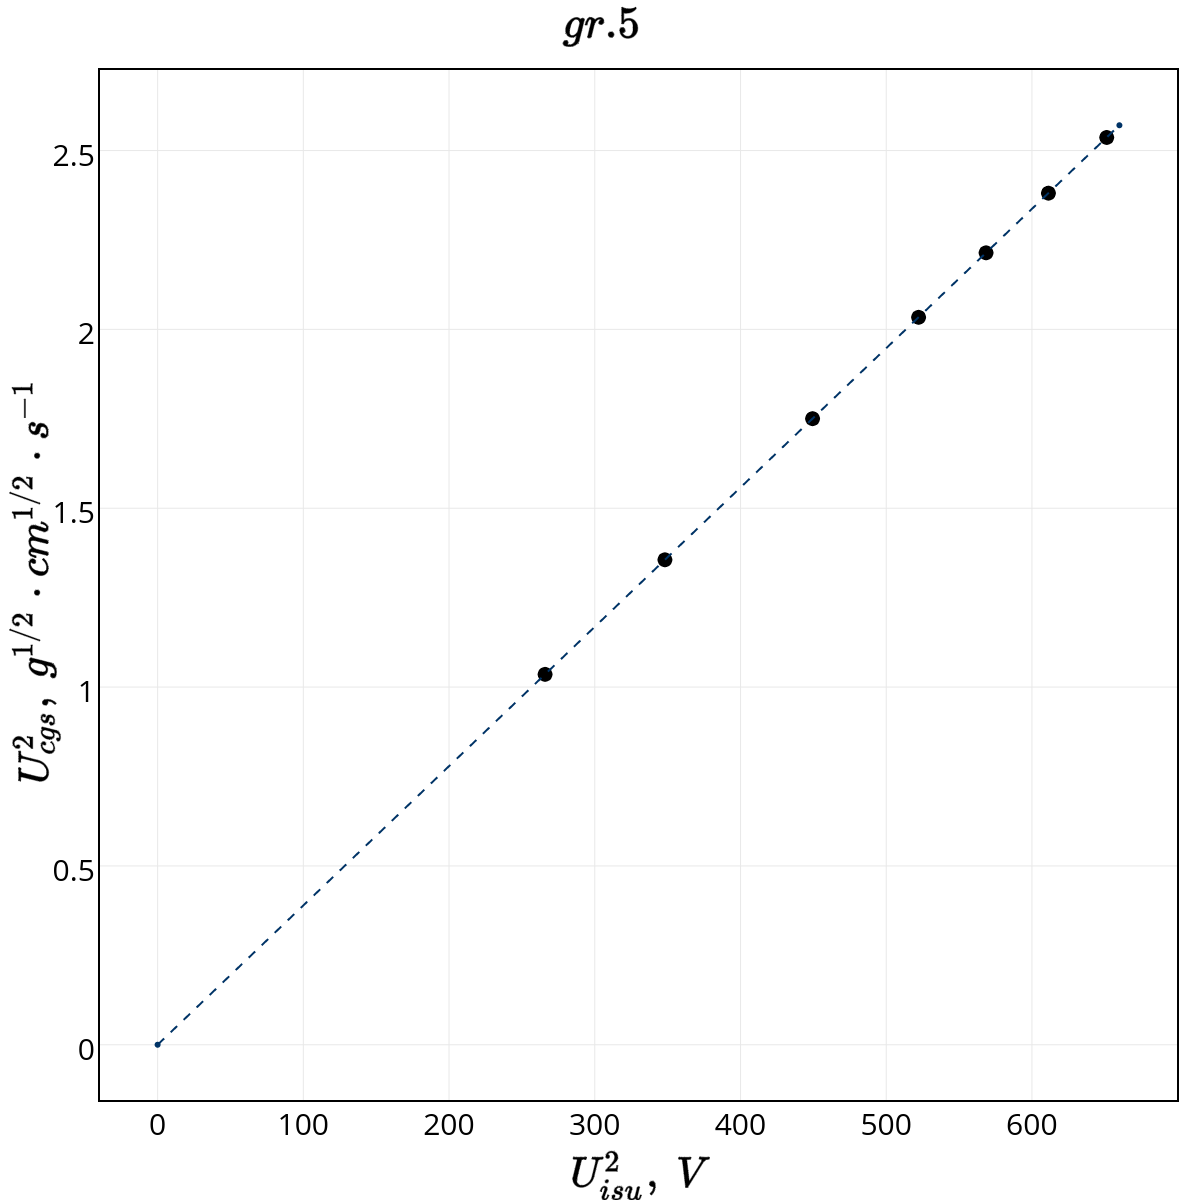

In [44]:
trace1 = go.Scatter(
    x = predictions,
    y = data_f['feature5'],
    mode = 'markers',
    name = 'gr1',
    marker = dict(
        size = 15,
        opacity = 1,
        color = '#000000'
    )
)

trace2 = go.Scatter(
    x = [0.0, 660],
    y = [0.0, (3.895)*660/1000],
    line = dict(
        color = ('#003366'),
        width = 2,
        dash = 'dash')
)

trace0 = [trace1, trace2]

layout = go.Layout(
    title = "$gr.5$",
    width = 1200,
    height = 1200,
    font = dict(
        size = 30,
        color = '#000000'
        ),
    showlegend=False,
    paper_bgcolor = '#ffffff',
    xaxis = dict(
        title = '$U_{isu}^2,~V$',
        #range = [0, 70],
        zeroline = False,
        ticklen = 0,
        color = '#000000',
        mirror = True,
        showline = True,
        linewidth = 2,
        titlefont = dict(
            size = 40,
            color = '#000000' 
            )
    ),
    yaxis = dict(
        title = '$U_{cgs}^2,~g^{1/2} \cdot cm^{1/2} \cdot s^{-1}$',
        #range = [0, 7],
        zeroline = False,
        ticklen = 0,
        color = '#000000',
        mirror = True,
        showline = True,
        linewidth = 2,
        titlefont = dict(
            size = 40,
            color = '#000000' 
            )
    ),
    margin = dict(
        l = 100,
        r = 23,
        t = 70,
        b = 100,
        pad = 0 
    )
    
)

fig = go.Figure(data=trace0, layout=layout)
#py.iplot(figure, filename='basic-error-bar')
py.image.save_as(fig, 'my_plot5.png')
#! open my_plot.png
from IPython.display import Image
Image("my_plot5.png", width=500)